# Installation of Packages

In [41]:
# !pip install -q tensorflow_datasets
# !pip install -q datasets
# !pip install -q keras_cv
# !pip install -q keras_hub
!pip install evaluate -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Download Dataset from external source

# Importing packages

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers

from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import DefaultDataCollator
import evaluate
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
# import torchvision
from datasets import load_dataset
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [2]:
dataset = load_dataset("DamarJati/Face-Mask-Detection")

README.md:   0%|          | 0.00/223 [00:00<?, ?B/s]

Dataset.zip:   0%|          | 0.00/346M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11792 [00:00<?, ? examples/s]

# Data Inspection / Visualization

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11792
    })
})

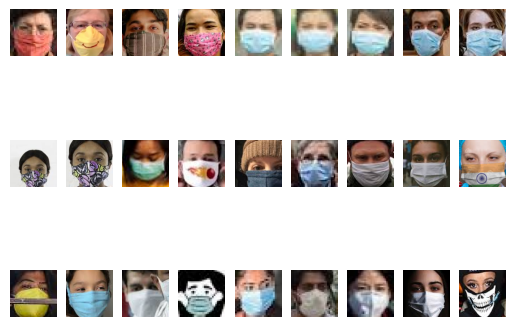

In [18]:
#plt.figure(figsize=(10,15))
for i in range(27):
    plt.subplot(3,9, i+1)
    plt.imshow(dataset["train"][i]['image'])
    plt.axis(False)

In [20]:
dataset["train"].features["label"].names

['WithMask', 'WithoutMask']

In [ ]:
# (1) Data does not have test and validation dataset
# (2) Assign labels to unique numbers
# (3) Convert Image to Tensor
# (4) Apply Image Augmentation

# Data Preprocessing

In [33]:
#(1)
ds = dataset["train"].train_test_split(test_size=0.1)

In [21]:
#(2)
categories = dataset["train"].features["label"].names
id2label = {k:v for k,v in enumerate(categories)}
label2id = {v:k for k,v in enumerate(categories)}

In [35]:
id2label, label2id

({0: 'WithMask', 1: 'WithoutMask'}, {'WithMask': 0, 'WithoutMask': 1})

# Data Postprocessing

In [30]:
#(3)
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)
image_processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [31]:
#(4)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = ( image_processor.size["height"], image_processor.size["width"])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [32]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [34]:
data = ds.with_transform(transforms)

In [45]:
train_ds = data['train']
val_ds = data['test']

# Model

In [37]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Compile

In [39]:
training_args = TrainingArguments(
    output_dir="nose_mask_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", 
)

# Fit

In [43]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [44]:
data_collator = DefaultDataCollator()

In [47]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds, 
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


# Evaluation

In [ ]:
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])
# plt.title("model accuracy")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(["train", "validation"], loc="upper left")
# plt.show()

# Inference

In [ ]:
ds = load_dataset("DamarJati/Face-Mask-Detection", split="train[:10]")
image = ds["image"][0]

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("Docty/nose_mask_model")
inputs = image_processor(image, return_tensors="pt")

In [ ]:
model = AutoModelForImageClassification.from_pretrained("Docty/nose_mask_model")
with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]